# Learning based methods

This is a model which takes a collection of images and figures out how to align them using an unsupervised approach. It is based on a paper by de Vos, Beredensen, Viergever, Sokooti, Staring, Isgum: [https://arxiv.org/pdf/1809.06130.pdf]().

In [47]:
import glob
import pandas as pd
import numpy as np

import tensorflow as tf

# for reproducibility
seed = 123
np.random.seed(seed) 
tf.set_random_seed(seed)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5816933914764105369
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3344629760
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14794943350296043776
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


## Data wrangling

In [221]:
def load_img_paths(target):
    '''
    Retrieve the full path of all images in the dataset
    '''
    return glob.glob(target + '/*.tif')

data_dir = r'../data'
original_data_dir = data_dir + ('/learning')
all_files = pd.read_csv(original_data_dir + '/horiz_pairs.csv')
all_files.head()

,Unnamed: 0,ref,mov
0,0,Tp26_Y000_X000_040.tif,Tp26_Y000_X001_040.tif
1,1,Tp26_Y000_X001_040.tif,Tp26_Y000_X002_040.tif
2,2,Tp26_Y000_X001_040.tif,Tp26_Y000_X000_040.tif
3,3,Tp26_Y000_X002_040.tif,Tp26_Y000_X003_040.tif
4,4,Tp26_Y000_X002_040.tif,Tp26_Y000_X001_040.tif


In [222]:
train_split = 0.9
valid_split = 0.1

all_files = all_files.sample(frac=1, random_state=123) # shuffle with seed 123 for reproducability
train_paths = []
valid_paths = []

if train_split <= 1:
    frac = int(all_files.shape[0] * train_split)
    train_paths = all_files[:frac].values.tolist()
    valid_paths = all_files[frac:].values.tolist()
else:
    valid_frac = int(train_split * valid_split)
    train_paths = all_files[:train_split].values.tolist()
    valid_paths = all_files[train_split:train_split+valid_frac].values.tolist()

assert(len(train_paths) > 0)
print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))

Traning images:    201
Validation images: 23


## Network

> A ConvNet design for affine image registration. The network analyzes pairs of fixed and moving images in separate pipelines. Ending each pipeline with global average pooling enables analysis of input images of different sizes, and allows concatenation with the fully connected layers that have a fixed number of nodes connected to 12 affne transformation parameter outputs.

> The two separate pipelines analyze input pairs of fixed and moving images and each consist of five alternating 3x3x3 convolution layers and 2x2x2 downsampling layers. The number of these layers may vary, depending on task complexity and input image size. The weights of the layers are shared between the two pipelines to limit the number of total parameters in the network.

> The Conv-Nets were initialized with Glorot's uniform distribution (Glorot and Bengio, 2010) and optimized with Adam.

> Subsequently, the network can be connected to a neural network work that will decode the relative orientations of the fixed and moving images and convert those to 12 affine transformation parameters: *three translation*, *three rotation*, *three scaling*, and *three shearing parameters*.

2D images -> 3 parameters

In [298]:
from keras import backend as K
from keras.layers.core import Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import Lambda, Input, Conv2D, AveragePooling2D, GlobalAveragePooling2D, concatenate, Reshape
from keras.models import Sequential, Model

from m_stn import BilinearInterpolation

class rigid_stn(BilinearInterpolation):

    '''
    n_batch = tf.shape(imgs)[0]
    coords = tf.reshape(mappings, [n_batch, 2, -1])
    x_coords = tf.slice(coords, [0, 0, 0], [-1, 1, -1])
    y_coords = tf.slice(coords, [0, 1, 0], [-1, 1, -1])
    x_coords_flat = tf.reshape(x_coords, [-1])
    y_coords_flat = tf.reshape(y_coords, [-1])

    output = _interpolate2d(imgs, x_coords_flat, y_coords_flat)
    return output
    '''
    
    def _interpolate(self, image, sampled_grids, output_size):

        batch_size = K.shape(image)[0]
        height = K.shape(image)[1]
        width = K.shape(image)[2]
        num_channels = K.shape(image)[3]

        x = K.cast(K.flatten(sampled_grids[:, 0:1]), dtype='float32')
        y = K.cast(K.flatten(sampled_grids[:, 1:2]), dtype='float32')

        x = .5 * (x + 1.0) * K.cast(width, dtype='float32')
        y = .5 * (y + 1.0) * K.cast(height, dtype='float32')

        x0 = K.cast(x, 'int32')
        x1 = x0 + 1
        y0 = K.cast(y, 'int32')
        y1 = y0 + 1

        max_x = int(K.int_shape(image)[2] - 1)
        max_y = int(K.int_shape(image)[1] - 1)

        x0 = K.clip(x0, 0, max_x)
        x1 = K.clip(x1, 0, max_x)
        y0 = K.clip(y0, 0, max_y)
        y1 = K.clip(y1, 0, max_y)

        pixels_batch = K.arange(0, batch_size) * (height * width)
        pixels_batch = K.expand_dims(pixels_batch, axis=-1)
        flat_output_size = output_size[0] * output_size[1]
        base = K.repeat_elements(pixels_batch, flat_output_size, axis=1)
        base = K.flatten(base)

        # base_y0 = base + (y0 * width)
        base_y0 = y0 * width
        base_y0 = base + base_y0
        # base_y1 = base + (y1 * width)
        base_y1 = y1 * width
        base_y1 = base_y1 + base

        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = K.reshape(image, shape=(-1, num_channels))
        flat_image = K.cast(flat_image, dtype='float32')
        pixel_values_a = K.gather(flat_image, indices_a)
        pixel_values_b = K.gather(flat_image, indices_b)
        pixel_values_c = K.gather(flat_image, indices_c)
        pixel_values_d = K.gather(flat_image, indices_d)

        x0 = K.cast(x0, 'float32')
        x1 = K.cast(x1, 'float32')
        y0 = K.cast(y0, 'float32')
        y1 = K.cast(y1, 'float32')

        area_a = K.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = K.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = K.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = K.expand_dims(((x - x0) * (y - y0)), 1)

        values_a = area_a * pixel_values_a
        values_b = area_b * pixel_values_b
        values_c = area_c * pixel_values_c
        values_d = area_d * pixel_values_d
        return values_a + values_b + values_c + values_d
    
    def _make_regular_grids(self, batch_size, height, width, *kwargs):
        # making a single regular grid
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = K.flatten(x_coordinates)
        y_coordinates = K.flatten(y_coordinates)
#         ones = K.ones_like(x_coordinates)
        grid = K.concatenate([x_coordinates, y_coordinates], 0)

        # repeating grids for each batch
        grid = K.flatten(grid)
        grids = K.tile(grid, K.stack([batch_size]))
        return K.reshape(grids, (batch_size, 2, height * width))
    
    def _transform(self, X, rigid_params, output_size):
        '''
        receives rigid parameters as [theta, x, y]
        '''
        batch_size = K.shape(X)[0]
        x_len, y_len = K.shape(X)[1], K.shape(X)[2]
        num_channels = K.shape(X)[3]

        regular_grids = self._make_regular_grids(batch_size, *output_size)
#         sampled_grids = K.batch_dot(transformations, regular_grids)
#         rigid_params = K.reshape(rigid_params, shape=(batch_size, 2))
        sampled_grids = regular_grids + K.reshape(rigid_params, shape=(batch_size, 2, 1))
        
        interpolated_image = self._interpolate(X, sampled_grids, output_size)
        new_shape = (batch_size, output_size[0], output_size[1], num_channels)
        interpolated_image = K.reshape(interpolated_image, new_shape)
        return interpolated_image

In [315]:
class NCC():
    """
    local (over window) normalized cross correlation
    """

    def __init__(self, win=None, eps=1e-5):
        self.win = win
        self.eps = eps


    def ncc(self, I, J):
        # get dimension of volume
        # assumes I, J are sized [batch_size, *vol_shape, nb_feats]
        ndims = len(I.get_shape().as_list()) - 2
        assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims

        # set window size
        if self.win is None:
            self.win = [9] * ndims

        # get convolution function
        conv_fn = getattr(tf.nn, 'conv%dd' % ndims)

        # compute CC squares
        I2 = I*I
        J2 = J*J
        IJ = I*J

        # compute filters
        sum_filt = tf.ones([*self.win, 1, 1])
        strides = [1] * (ndims + 2)
        padding = 'SAME'

        # compute local sums via convolution
        I_sum = conv_fn(I, sum_filt, strides, padding)
        J_sum = conv_fn(J, sum_filt, strides, padding)
        I2_sum = conv_fn(I2, sum_filt, strides, padding)
        J2_sum = conv_fn(J2, sum_filt, strides, padding)
        IJ_sum = conv_fn(IJ, sum_filt, strides, padding)

        # compute cross correlation
        win_size = np.prod(self.win)
        u_I = I_sum/win_size
        u_J = J_sum/win_size

        cross = IJ_sum - u_J*I_sum - u_I*J_sum + u_I*u_J*win_size
        I_var = I2_sum - 2 * u_I * I_sum + u_I*u_I*win_size
        J_var = J2_sum - 2 * u_J * J_sum + u_J*u_J*win_size

        cc = cross*cross / (I_var*J_var + self.eps)

        # return negative cc.
        return tf.reduce_mean(cc)

    def loss(self, I, J):
        return 1 - self.ncc(I, J)

def correlation_coefficient_loss(y_true, y_pred):
    '''
    Same as pearson coefficient
    https://stackoverflow.com/a/46620771
    '''
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r_den = K.maximum(r_den, 1.0)
    r = r_num / r_den # this can produce NaN

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return  - K.square(r)

def SSD_loss(x, y):
    '''
    Sum squared differences
    '''
    return K.square(x - y)

def get_initial_weights(output_size):
    '''
    Initialize the weights as an identity matrix.
    '''
    b = np.array([[1., 0, 0], [0, 1., 0]], dtype='float32')
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights

def dlir_layer(m1, m2, filters):
    '''
    alternating 3x3 convolution layers and 2x2 downsampling layers
    '''
    conv= Conv2D(filters, (3,3), activation='relu', padding='same')
    avg = AveragePooling2D(padding='same') # default size is 2x2
    return avg(conv(m1)), avg(conv(m2))
    
def affine_pipeline(input_shape, conv_layers, filters=32):
    '''
    five alternating 3x3 convolution layers and 2x2 downsampling layers
    Ending each pipeline with global average pooling
    '''
    assert conv_layers >= 1, 'There needs to be at least one conv layer'
    in1 = Input(shape=input_shape, name='reference_input')
    in2 = Input(shape=input_shape, name='moving_input')
    
    for i in range(0,conv_layers):
        if i == 0:
            m1, m2 = dlir_layer(in1, in2, filters)
        m1, m2 = dlir_layer(m1, m2, filters)
    
    conv = Conv2D(filters, (3,3), activation='relu', padding='same')
    glob_avg = GlobalAveragePooling2D()
    
    return in1, in2, glob_avg(conv(m1)), glob_avg(conv(m2))
    
def my_DLIR(input_shape, conv_layers=4, filters=32, dense_size=1024):
    '''
    Implement DLIR architecture
    '''
    input_1, input_2, moving_pipeline, reference_pipeline = affine_pipeline(input_shape, conv_layers)
    
    cat = concatenate([moving_pipeline, reference_pipeline])
    cat = Dense(dense_size, activation='relu')(cat)
    rigid_transform = Dense(2, activation='linear', name='rigid_params')(cat)
#     affine_transform = Dense(6, activation='linear', weights=get_initial_weights(dense_size), \
#                             name='affine_params')(cat)
    image_output = rigid_stn(input_shape[:-1])([input_2, rigid_transform])
#     image_output = BilinearInterpolation(input_shape[:-1])([input_2, affine_transform])
    
    return Model(inputs=[input_1, input_2], outputs=[image_output])

In [321]:
from keras.optimizers import Adam
from skimage.io import imread

def aspect_resize(newsize, shape):
    '''
    Given an integer and a shape, return a tuple with the longest side of the shape = newsize
    '''
    m = np.argmax(shape)
    if m == 0:
        return (newsize, int(shape[1] / (shape[0] / newsize)))
    return (int(shape[0] / (shape[1] / newsize)), newsize, 1)

orig_shape = imread(original_data_dir + '/' + train_paths[0][1]).shape
img_size = aspect_resize(256, orig_shape)

if len(img_size) == 2:
    img_size = (*img_size, 1)

my_model = my_DLIR(img_size, conv_layers=4, filters=32, dense_size=1024)
lr = 1e-3
my_model.compile(loss='mse', optimizer=Adam(lr=lr))
# my_model.compile(loss=NCC().loss, optimizer=Adam(lr=lr))
# my_model.compile(loss=SSD_loss, optimizer=Adam(lr=lr))
my_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
moving_input (InputLayer)       (None, 195, 256, 1)  0                                            
__________________________________________________________________________________________________
reference_input (InputLayer)    (None, 195, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_321 (Conv2D)             (None, 195, 256, 32) 320         reference_input[0][0]            
                                                                 moving_input[0][0]               
__________________________________________________________________________________________________
average_pooling2d_269 (AverageP (None, 98, 128, 32)  0           conv2d_321[0][0]                 
          

In [322]:
import math
from os import path
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import Sequence
from skimage.transform import resize, rotate


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
    
class DataGenerator(Sequence):
    '''
    Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
    Allows for multiprocessing in the fit generator
    '''

    def __init__(self, train_set, batch_size, im_size, train_dir):
        self.train = train_set
        self.batch_size = batch_size
        self.im_size = im_size
        self.train_dir = train_dir

    def __len__(self):
        return int(np.ceil(len(self.train) / float(self.batch_size)))

    def read_image(self, fname):
        return load_img(fname, target_size=self.im_size, grayscale=True)
    
    def read_images(self, f1, f2):
        f1 = path.join(self.train_dir, f1)
        f2 = path.join(self.train_dir, f2)
        x1 = load_img(f1, target_size=self.im_size, grayscale=True)
        x2 = load_img(f2, target_size=self.im_size, grayscale=True)
        return img_to_array(x1), img_to_array(x2)
    
    # Will output sequence of tuples (image, test) given a datapath
    def __getitem__(self, idx):
        X1 = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 1))
        X2 = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 1))
        y  = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 1))
        batch = self.train[idx * self.batch_size:(idx + 1) * self.batch_size]
        for j,row in enumerate(batch):
            # to speed this up: preprocess the images so they aren't resized on the fly
            ref, mov = row[1:]
            X1[j], X2[j] = self.read_images(ref, mov)
            y[j] = X1[j]
        return ([X1, X2], y)

    
class AugmentedDataGenerator(DataGenerator):
    '''
    Same as DataGenerator but augments data by overriding `read_image`.
    '''
    
#     def rand_augment(self, img):
#         minmax = 45 # in the range of -45 to 45
#         angle = np.random.randint(0, high=minmax) - (minmax*2)
#         return rotate(img, -angle)
    
    def read_images(self, f1, f2):
        '''
        reflection augmentations
        '''
        f1 = path.join(self.train_dir, f1)
        f2 = path.join(self.train_dir, f2)
        x1 = img_to_array(load_img(f1, target_size=self.im_size, grayscale=True))
        x2 = img_to_array(load_img(f2, target_size=self.im_size, grayscale=True))
        flip_dir = np.random.choice([None, 0, 1, 2])
        if flip_dir == None:
            return x1, x2
        elif flip_dir < 2:
            x1 = np.flip(x1, flip_dir)
            x2 = np.flip(x2, flip_dir)
        else: # flip_dir == 2
            x1 = np.flip(np.flip(x1, 0),1)
            x2 = np.flip(np.flip(x2, 0),1)
        return x1, x2
    
    
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')

history = LossHistory()

tmp directory already exists


In [323]:
batch_size = 16
epochs     = 50

training_generator   = AugmentedDataGenerator(train_paths, batch_size, img_size, original_data_dir)
validation_generator = DataGenerator(valid_paths, batch_size, img_size, original_data_dir)

# descriptive weight file naming
checkpointer = ModelCheckpoint(filepath=('tmp/weights-%d-%d.hdf5' % 
                                         (batch_size, img_size[0])), 
                               verbose=1, save_best_only=True)

hist = my_model.fit_generator(training_generator,
                              validation_data=validation_generator,
                              epochs=epochs,
                              workers=3,
                              verbose=2,
                              callbacks=[history, checkpointer, early_stopping]
)

Epoch 1/50
 - 10s - loss: 32728.2395 - val_loss: 25532.4683

Epoch 00001: val_loss improved from inf to 25532.46826, saving model to tmp/weights-16-195.hdf5
Epoch 2/50
 - 1s - loss: 34011.4776 - val_loss: 25532.4683

Epoch 00002: val_loss did not improve from 25532.46826
Epoch 3/50
 - 1s - loss: 34011.4775 - val_loss: 25532.4683

Epoch 00003: val_loss did not improve from 25532.46826
Epoch 4/50
 - 1s - loss: 34011.4781 - val_loss: 25532.4683

Epoch 00004: val_loss did not improve from 25532.46826
Epoch 5/50
 - 1s - loss: 34011.4781 - val_loss: 25532.4683

Epoch 00005: val_loss did not improve from 25532.46826
Epoch 6/50
 - 1s - loss: 34011.4772 - val_loss: 25532.4683

Epoch 00006: val_loss did not improve from 25532.46826
Epoch 00006: early stopping


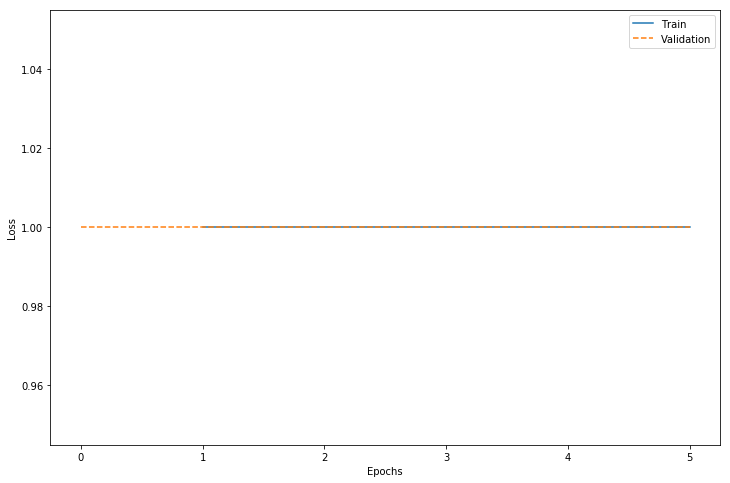

In [319]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12,8))

plt.plot(hist.epoch[1:],hist.history['loss'][1:], label='Train')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


../data/learning/Tp26_Y004_X010_040.tif ../data/learning/Tp26_Y004_X011_040.tif
[-0.00411083  0.02858193]


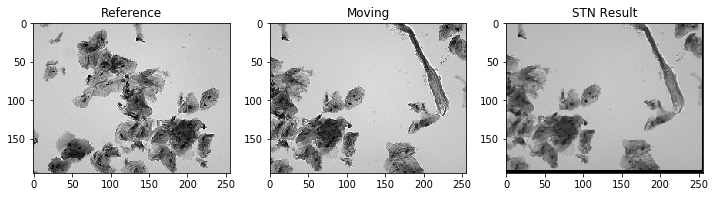

In [320]:
import random

def show_registration(ref, mov, res):
    fig, (a, b, c) = plt.subplots(1, 3, figsize=(12, 8))
    a.imshow(ref, cmap='gray')
    a.set_title('Reference')
    b.imshow(mov, cmap='gray')
    b.set_title('Moving')
    c.imshow(res, cmap='gray')
    c.set_title('STN Result')
    plt.show()

row = train_paths[random.randint(0, len(train_paths))]
f1 = original_data_dir + '/' + row[1]
f2 = original_data_dir + '/' + row[2]

im1 = resize(imread(f1), img_size).reshape(-1, *img_size)
im2 = resize(imread(f2), img_size).reshape(-1, *img_size)
# im2 = resize(rotate(imread(train_paths[1]), 10), img_size).reshape(-1, *img_size)

im3 = my_model.predict([im1, im2])

# a model which does not include the STN and outputs the predicted affine translation
intermediate_model = Model(inputs=[my_model.get_layer('reference_input').input, 
                                   my_model.get_layer('moving_input').input], 
                           outputs=[my_model.get_layer('rigid_params').output])
M = intermediate_model.predict([im1, im2])[0]
print(f1,f2)
print(M)
# plt.imshow(im3[0][:,:,-1], cmap='gray')
show_registration(im1[0][:,:,-1], im2[0][:,:,-1], im3[0][:,:,-1])